In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import numpy.random as alea
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
from torchvision import transforms
from random import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import progressbar
import momAPI.nn.indexed_dataset as indexed_dataset
import momAPI.nn.utilities as utilities
import momAPI.nn.MOM_training as MOM_training
import momAPI.nn.MOM_sampler as MOM_sampler
from math import log
import torch.utils.data as data
import time

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
random_seed = 7
alea.seed(random_seed)

#### Data importation

We want to classify the images of tiny-imageNet

In [4]:
images = []
targets = []
min_n , min_p = 1000 , 1000
n_samples, i = 0, 0
types = os.listdir("/Users/charleslaroche/Downloads/tiny-imagenet-200/train")
for typ in progressbar.progressbar(types[:10]):
    
    file = os.listdir("/Users/charleslaroche/Downloads/tiny-imagenet-200/train/" + typ + "/images")
    
    for f in file: 
        
        img = Image.open("/Users/charleslaroche/Downloads/tiny-imagenet-200/train/" + typ + "/images/" + f)
        n,p = img.size
        #height = min(n,p)
        #box = ( 0 , 0 , height , height)
        #img = img.crop(box)  # On rend l'image carré en la rognant
        if len(np.array(img).shape) == 3 : 
            images.append(np.array(img)/255)
            targets.append(i)
        
    i += 1

100% (10 of 10) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(images, targets, random_state = random_seed)

In [6]:
target_train = torch.LongTensor(Y_train)
target_test = torch.LongTensor(Y_test)

### Data transformation

First we create a transformer in order to transform np.array to torch.tensor with the channels in the first dimension.

In [7]:
transformer = transforms.Compose( [ transforms.ToTensor()])

In [8]:
data_train = indexed_dataset.Dataset(X_train , target_train , transform = transformer)
data_test = indexed_dataset.Dataset(X_test , target_test , transform = transformer)

### The network

In [9]:
class CNN(torch.nn.Module):
    
    #Our batch shape for input x is (3 , 64 , 64)
    
    def __init__(self):
        super(CNN, self).__init__()
        
        #input channels = 3, output channels = 16
        self.block_1 = nn.Sequential(torch.nn.Conv2d(3 , 32 , 3 , stride = 1 , padding = 0),
                                     nn.BatchNorm2d(32),
                                     nn.ReLU(),
                                     torch.nn.MaxPool2d(3))
        
        #Input channels = 16, output channels = 32
        self.block_2 = nn.Sequential(torch.nn.Conv2d(32 , 64 , 3 , stride = 1 , padding = 0),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(),
                                     torch.nn.MaxPool2d(2))
        
        #Input channels = 32, output channels = 64
        self.block_3 = nn.Sequential(torch.nn.Conv2d(64 , 128 , 3 , stride = 1 , padding = 0),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(),
                                     torch.nn.MaxPool2d(2))
        
        #128 input features, 1 output features for binary classification
        self.fc1 = torch.nn.Linear(1152, 10)
        
        self.conv_dropout = nn.Dropout2d(p = 0.0)
        self.dense_dropout = nn.Dropout(p = 0.5)
        
    def forward(self, x):
        #print("1:", (x == x).all())
        #Computes the Fivation of the first convolution
        #Size changes from (3, 64, 64) to (16, 32, 32)
        x = self.block_1(x)
        #print(x.size())
        #print("1:", (x == x).all())
        
        #Size changes from (16, 32, 32) to (32, 16, 16)
        x = self.block_2(x)
        #print(x.size())
        #print("2:", (x == x).all())
        
        #Size changes from (32, 16, 16) to (64, 6, 6)
        x = self.block_3(x)
        #print(x.size())
        #print("3:", (x == x).all())
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (128 , 1 , 1) to (1, 128)
        #Recall that the -1 infers this dimension from the other given dimension
        #print(x.size())
        x = x.view(-1,1152)
        
        #Computes the Fivation of the fully connected layer
        #Size changes from (1, 2304) to (1, 1)
        x = torch.nn.functional.softmax(self.dense_dropout(self.fc1(x)),dim = 1)
        return(x)

We use Adam optimizer and our loss is the classical cross entropy which on M classes can be calculated with the following formula : 
$$ CE(y,\widehat{y}) = -\sum_{c = 1}^{M}{y_c log(\widehat{y}_c)+(1-y_c)log(1-\widehat{y}_c)}$$
with $y,\widehat{y} \in \mathbb{R}^M$ and $y_i$ (resp $\widehat{y}_i$) denotes the i-th element of y (resp $\widehat{y}$).

In [10]:
model = CNN()
optimizer = torch.optim.Adam( CNN_.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,
                                          weight_decay=0, amsgrad=False)
loss = torch.nn.CrossEntropyLoss()

n_epochs = 600
batch_size = 32
n_hist = 30
history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': [], 'hist': []}
device = 'cpu'
K = len(data_train) // batch_size

sampler = MOM_sampler.MomSampler(model, data_train, K, loss=loss, random_state=True, device=device)

In [11]:
# Training loader 
train_loader = data.DataLoader(data_train, num_workers=1, sampler=sampler, batch_size=batch_size)

# Validation loader
val_loader = data.DataLoader(data_test, batch_size=len(data_test))
val_inputs, val_labels, _ = val_loader.__iter__().next()
val_inputs, val_labels = val_inputs.float().to(device), val_labels.long().to(device)

for epoch in range(n_epochs):
    t1 = time.time()
    
    # get the input
    inputs, labels, indexes = train_loader.__iter__().next()
    running_loss = 0.0
    running_val_loss = 0.0
    
    if epoch >= n_epochs - n_hist:
         history['hist'] += list(indexes)
    
    # Gradient descent step
    inputs = Variable(inputs.float().to(device), requires_grad=True)
    labels = labels.long().to(device)
    optimizer.zero_grad()  # zero the parameter gradients
    loss_ =  loss(model(inputs), labels)
    loss_.backward()  # compute the gradient of the loss
    optimizer.step()
    running_loss += loss_.item()
        
    # Updating loss and accuracy
    with torch.no_grad():
        val_loss_ = loss(model(val_inputs), val_labels)
        running_val_loss += val_loss_.item()
        history['val_loss'].append(running_val_loss)
    
    history['loss'].append(running_loss)
               
    accu = utilities.accuracy( model, data_train, device= device)
    history['acc'].append(accu)
    
    with torch.no_grad():
        val_accu = utilities.accuracy( model, data_test, device= device)
        history['val_acc'].append(val_accu)
        t2 = time.time()
        print("Epoch n°{} ({}sec) : loss = {}, validation loss = {}, accuracy = {},"
              " validation accuracy = {}".format(str(epoch), str((t2 - t1) // 1), str(running_loss),
                                                 str(running_val_loss), str(accu), str(val_accu)))
print("Training finished")

Epoch n°0 (45.0sec) : loss = 2.319223642349243, validation loss = 2.2809557914733887, accuracy = 0.14165535956580733, validation accuracy = 0.1497152156224573
Epoch n°1 (37.0sec) : loss = 2.2504682540893555, validation loss = 2.281418561935425, accuracy = 0.14925373134328357, validation accuracy = 0.1562245728234337
Epoch n°2 (45.0sec) : loss = 2.298947811126709, validation loss = 2.266918897628784, accuracy = 0.1525101763907734, validation accuracy = 0.1676159479251424
Epoch n°3 (38.0sec) : loss = 2.201406717300415, validation loss = 2.2658259868621826, accuracy = 0.15169606512890094, validation accuracy = 0.1724979658258747
Epoch n°4 (40.0sec) : loss = 2.3340601921081543, validation loss = 2.2646894454956055, accuracy = 0.14925373134328357, validation accuracy = 0.17331163547599673
Epoch n°5 (39.0sec) : loss = 2.3157858848571777, validation loss = 2.2654850482940674, accuracy = 0.15359565807327002, validation accuracy = 0.1643612693246542
Epoch n°6 (40.0sec) : loss = 2.33367013931274

KeyboardInterrupt: 

Text(0.5, 1.0, 'Training curve')

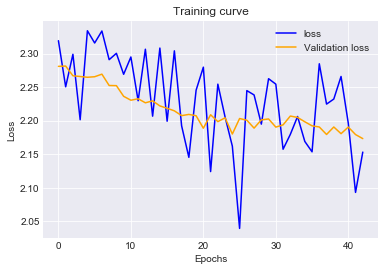

In [12]:
%matplotlib inline
plt.plot(history['loss'] , color = "blue" , label = "loss")
plt.plot(history['val_loss'] , color = 'orange' , label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training curve")

Text(0.5, 1.0, 'Training curve')

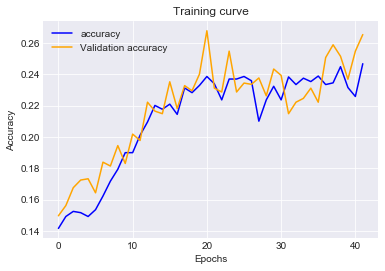

In [14]:
%matplotlib inline
plt.plot(history['acc'] , color = "blue" , label = "accuracy")
plt.plot(history['val_acc'] , color = 'orange' , label = "Validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training curve")

#### Model evaluation

In [15]:
%matplotlib inline

test_data_x = torch.stack([data_test[i][0] for i in range(len(data_test))]).float()
test_data_y = torch.stack([data_test[i][1] for i in range(len(data_test))]).long()
X = torch.Tensor(test_data_x)
Y = torch.LongTensor(test_data_y)
    
Y_pred = model(X)
Y_real = np.array(Y)
#cm = confusion_matrix(Y_real , Y_pred)

#plot_confusion_matrix(cm , ['crocodile','pinguin'])

In [16]:
l = []
for i in Y_pred.detach().numpy():
    l.append(np.argmax(i))
np.array(l)

array([8, 9, 8, ..., 1, 5, 5])

Normalized confusion matrix
[[0.04237288 0.29661017 0.21186441 0.         0.03389831 0.19491525
  0.         0.03389831 0.08474576 0.10169492]
 [0.07142857 0.3968254  0.11904762 0.         0.05555556 0.06349206
  0.         0.03968254 0.08730159 0.16666667]
 [0.05691057 0.16260163 0.51219512 0.         0.         0.1300813
  0.         0.00813008 0.00813008 0.12195122]
 [0.15652174 0.12173913 0.13913043 0.0173913  0.         0.13913043
  0.         0.03478261 0.26956522 0.12173913]
 [0.0862069  0.13793103 0.01724138 0.02586207 0.3362069  0.00862069
  0.         0.02586207 0.09482759 0.26724138]
 [0.08264463 0.10743802 0.12396694 0.         0.01652893 0.39669421
  0.         0.09917355 0.11570248 0.05785124]
 [0.09448819 0.21259843 0.12598425 0.         0.11023622 0.14173228
  0.         0.05511811 0.13385827 0.12598425]
 [0.11538462 0.17692308 0.02307692 0.         0.01538462 0.24615385
  0.         0.23076923 0.11538462 0.07692308]
 [0.06569343 0.27007299 0.08759124 0.00729927 0.02189

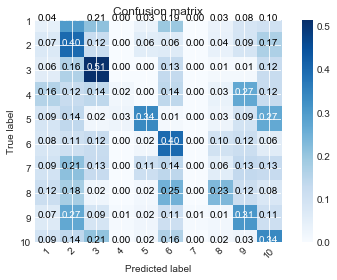

In [17]:
%matplotlib inline
cm = confusion_matrix(Y_real , l)

utilities.plot_confusion_matrix(cm, [1,2,3,4,5,6,7,8,9,10], normalize = True)

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_real , l)

0.25874694873881204